In [2]:
ENV='MiniHack-KeyRoom-S15-v0'
# ENV='MiniHack-CorridorBattle-v0'
H = 10
W = 10
NUM_EPISODES = 1
MAX_STEPS = 350
PATH = 'kbkey.pl'



In [3]:
from utilsk import decide_next_cell_to_explore, initialize,perform_action,coordinates_to_actions,astar,obschar_to_mask, actions, positions,  process_state, show_match
from pyswip import Prolog
import matplotlib.pyplot as plt
import numpy as np
import time


In [4]:
KB = Prolog()
KB.consult(PATH)

In [5]:
import gym
import minihack
import matplotlib.pyplot as plt
from minihack import LevelGenerator
from nle import nethack

map = """
--------------------------------------
|....................................|
|..-----....|..|.............|.......|
|..|   |..--|--|-------...------.....|
|..--- |....|..|.....................|
|....| ||......||....-----......|....|
|....|  |-------.........|......|....|
|....|  |................|||..|||....|
------  |-------....------......|....|
        |......|................|..|||
        |......--------.........|....|
        |.............|---------|....|
        |..............#########.....|
        |.............|---------|....|
        ------------------------------ 
"""

lvl_gen = LevelGenerator(map=map, lit=False)
lvl_gen.set_start_pos((3, 6))
lvl_gen.add_monster(name="giant rat", place=(10, 11))
lvl_gen.add_monster(name="giant rat", place=(10, 12))
lvl_gen.add_monster(name="giant rat", place=(10, 13))
lvl_gen.add_monster(name="giant rat", place=(11, 11))
lvl_gen.add_monster(name="giant rat", place=(11, 12))
lvl_gen.add_monster(name="giant rat", place=(11, 13))
lvl_gen.add_door("closed", place=(32,12))
lvl_gen.add_object(name='skeleton key', symbol='(', place=(28,7))
lvl_gen.add_goal_pos((11, 10))

initialize()

MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.OPEN
)

env = gym.make("MiniHack-Skill-Custom-v0",
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'),
               des_file = lvl_gen.get_des(),
               max_episode_steps=600,
               actions = NAVIGATE_ACTIONS)
obs=env.reset() # each reset generates a new environment instance
env.render()





Hello Agent, welcome to NetHack!  You are a neutral human Caveman.              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                      ...                                                       
                      .@.                                                       
                      ...                                                       
                           

east


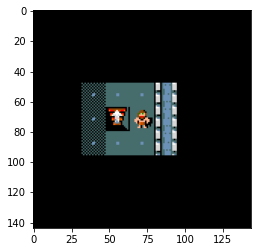

In [22]:
obs, reward, done, info=perform_action('east', env, KB)
plt.imshow(obs['pixel_crop'])

In [23]:
process_state(obs, KB)
action = list(KB.query('action(X)'))[0]["X"]
action

'explore'

In [24]:
positions["agent"]

(9, 24)

In [7]:
rewards = []
performed_acts=[]

def run(obs,performed_acts):
    initialize()

    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    # obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False
    info=None

    # Main loop
    plan=[]
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
       
        action = list(KB.query('action(X)'))[0]["X"]
      
        # print(f'>> Current action from Prolog: {action}')
        
        if action:
            print(action)
            navs=[]
            if 'go(stairs)' in action:
                agent_p=positions['agent']
                stairs_p=positions['stairs']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, stairs_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'enter(door)' in action:
                agent_p=positions['agent']
                door_p=positions['door']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'opendoor' in action:
                obs, reward, done, info = perform_action("opendoor", env, KB)
                performed_acts+=["opendoor"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "pick" in action:
                obs, reward, done, info = perform_action("pick", env, KB)
                performed_acts+=["pick"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            if "go(door)" in action:
                agent_p=positions['agent']
                door_p=positions['door_front']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            elif "go(key)" in action:
                agent_p=positions['agent']
                key_p=positions['key']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, key_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'explore' in action:
                b_cell=decide_next_cell_to_explore(obs)
                agent_p=positions['agent']
                masked=obschar_to_mask(obs)
                print(agent_p,b_cell)
                path = astar(masked,agent_p, b_cell)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            for nav in navs:
                performed_acts+=[nav]

                if list(KB.query('action(X)'))[0]["X"] != action:
                    break
                    
                obs, reward, done, info = perform_action(nav, env, KB)
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                # env.render()
                
                

        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break


    # Display game with interface
    show_match(ep_states,0,600,250,1350)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    # rewards.append(reward)

    # # reset the environment and retract axioms that may cause errors
    # obs = env.reset()
    # KB.retractall('stepping_on(agent,_,_)')
    


KeyboardInterrupt: 

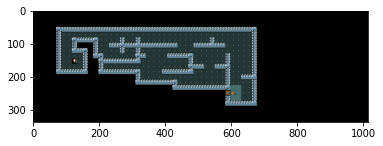

In [8]:
for episode in range(NUM_EPISODES):
    run(obs,performed_acts)
    


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

In [9]:
performed_acts

['north',
 'west',
 'south',
 'south',
 'east',
 'east',
 'north',
 'north',
 'west',
 'northwest',
 'west',
 'south',
 'south',
 'south',
 'north',
 'north',
 'north',
 'north',
 'north',
 'east',
 'north',
 'west',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'south',
 'south',
 'west',
 'south',
 'east',
 'east',
 'east',
 'south',
 'west',
 'west',
 'north',
 'north',
 'northeast',
 'east',
 'north',
 'east',
 'east',
 'south',
 'east',
 'north',
 'east',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'east',
 'east',
 'south',
 'west',
 'south',
 'east',
 'east',
 'north',
 'north',
 'north',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'northeast',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'south',
 'south',
 'west',
 'west',
 'east',
 'east',
 'southeast',
 'north',
 'north',
 'north',
 'east',
 'south',
 'south',
 'south',
 'south',
 'w

In [8]:
env.render()


                                                                                
                                                                                
                                                                                
                                                                                
--------------------------------------                                          
|....................................|                                          
|..-----....|..|.............|.......|                                          
|..|   |..-------------...------.....|                                          
|..--- |....|..|.....................|                                          
|....| --......|-....-----......|....|                                          
|..<.|  |-------.........|......|....|                                          
|....|  |................|--..--|....|                                          
------  |-------....------.

south


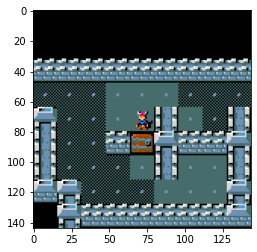

In [28]:
obs, reward, done, info=perform_action("opendoor", env, KB)
plt.imshow(obs['pixel_crop'])

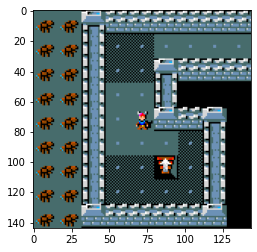

In [7]:
obs, reward, done, info = env.step(9)

In [9]:
 bytes(obs['message']).decode('utf-8').rstrip('\x00')

'There is nothing here to pick up.'

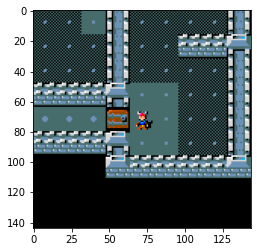

In [9]:
plt.imshow(obs['pixel_crop'])

In [10]:
for obj in obs['inv_strs']:
        obj = bytes(obj).decode('utf-8').rstrip('\x00')
        print(obj)

a +1 club (weapon in hand)
a +2 sling (alternate weapon; not wielded)
18 uncursed flint stones (in quiver pouch)
28 uncursed rocks
an uncursed +0 leather armor (being worn)
a key



















































In [24]:
APPLY_ACTIONS

(<CompassDirection.N: 107>,
 <CompassDirection.E: 108>,
 <CompassDirection.S: 106>,
 <CompassDirection.W: 104>,
 <CompassDirection.NE: 117>,
 <CompassDirection.SE: 110>,
 <CompassDirection.SW: 98>,
 <CompassDirection.NW: 121>,
 <Command.PICKUP: 44>,
 <Command.APPLY: 97>,
 <Command.OPEN: 111>)